In [1]:
import sys
sys.path.append('/home/kuchoco97/work/fpn_rcnn/model/rpn/')
sys.path.append('/home/kuchoco97/work/fpn_rcnn/model/')

import os
import numpy as np
import json
import matplotlib.pyplot as plt

from torch import nn
from torch.utils.data import DataLoader
import torch
import torch.nn.functional as F

from model.fpn.resnet import resnet101
from data.dataset import BrainDataset, collater
from model.fpn.fpn import FPN 
from model.rpn.generate_anchors import generate_anchors, generate_anchors_all_pyramids


from model.nms.nms import non_max_suppression as nms
from model.rpn.bbox_transform import clip_boxes, bbox_overlaps_batch, bbox_transform_batch, bbox_transform_inv

In [1]:
import sys
sys.path.append('/home/kuchoco97/work/fpn_rcnn/model/rpn/')
sys.path.append('/home/kuchoco97/work/fpn_rcnn/model/')
import os
import numpy as np
import json
import matplotlib.pyplot as plt

from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch


from model.fpn.resnet import resnet101
from data.dataset import BrainDataset, collater
from model.fpn.fpn import FPN 
from model.rpn.rpn_fpn import _RPN_FPN


In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'

In [3]:
with open('./data/train.json', 'r') as file:
    train_json = json.load(file)

with open('./data/valid.json', 'r') as file:
    valid_json = json.load(file)
    
    
train_ds = BrainDataset(train_json)
valid_ds = BrainDataset(valid_json)

train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collater , shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=16, num_workers=4, collate_fn=collater , shuffle=True)

In [4]:
x, y = next(iter(train_dl))

In [5]:
resnet = resnet101()

in_features = resnet.fc.in_features
resnet.fc = nn.Linear(in_features=in_features, out_features=2)
param = torch.load('/home/kuchoco97/work/brain/data/backbone/model/epoch20_valloss0.33.pth')
resnet.load_state_dict(param)

resnet.eval()

c1,c2,c3,c4,c5 = resnet.stages()

fpn = FPN(c1,c2,c3,c4,c5)

p2, p3, p4, p5, p6 = fpn(x)

/opt/conda/lib/python3.8/site-packages/torch/nn/functional.py:2925: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


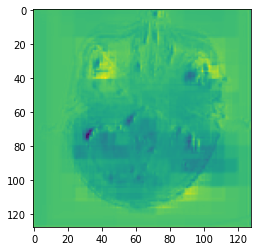

In [6]:
plt.imshow(p2[0,0,:,:].detach().numpy() )

# RPN train

In [7]:
batch_size = 16
rpn = _RPN_FPN(256)
rpn_feature_maps = [p2, p3, p4, p5, p6]
im_info = np.array(batch_size*[[512,512,1]], dtype=np.int32)
gt_boxes = y.data
num_boxes = 16

optimizer = torch.optim.Adam(rpn.parameters())

In [8]:
rois, rpn_loss_cls, rpn_loss_box = rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)

loss = rpn_loss_cls + rpn_loss_box
print('loss: ', loss.data)
loss.backward()
optimizer.step()

rois, rpn_loss_cls, rpn_loss_box = rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)

loss = rpn_loss_cls + rpn_loss_box
print('loss after step : ', loss.data)

/home/kuchoco97/work/fpn_rcnn/model/rpn/rpn_fpn.py:71: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)
/home/kuchoco97/work/fpn_rcnn/model/rpn/rpn_fpn.py:105: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:962.)
  rpn_keep = Variable(rpn_label.view(-1).ne(-1).nonzero().view(-1))


loss:  tensor(0.6790, grad_fn=<AddBackward0>)
after step loss:  tensor(0.5396, grad_fn=<AddBackward0>)


In [ ]:
blob = {'data': img,
        'im_info': (shape1,shape2,scale),
        'gt_boxes': bbox,
        'img_id': ids}


data = img
im_info = (shape1,shape2,scale)
gt_boxes = bboxs
__getitem__ return data, im_info,gt_boxes, num_boxes



######################################### Training #################################################
FPN = resnet(imdb.classes, 101, pretrained=True, class_agnostic=args.class_agnostic)
        self.RCNN_cls_score = nn.Linear(1024, self.n_classes)
        self.RCNN_bbox_pred = nn.Linear(1024, 4 * self.n_classes)
        
FPN.zero_grad()
_, _, _, rpn_loss_cls, rpn_loss_box, \
       RCNN_loss_cls, RCNN_loss_bbox, \
       roi_labels = FPN(im_data, im_info, gt_boxes, num_boxes)





####################### _FPN ################
    
from model.rpn.rpn_fpn import _RPN_FPN
from model.roi_pooling.modules.roi_pool import _RoIPooling
from model.roi_crop.modules.roi_crop import _RoICrop
from model.roi_align.modules.roi_align import RoIAlignAvg
from model.rpn.proposal_target_layer import _ProposalTargetLayer
from model.utils.net_utils import _smooth_l1_loss, _crop_pool_layer, _affine_grid_gen, _affine_theta


self.RCNN_rpn = _RPN_FPN(self.dout_base_model)
self.RCNN_proposal_target = _ProposalTargetLayer(self.n_classes)

# NOTE: the original paper used pool_size = 7 for cls branch, and 14 for mask branch, to save the
# computation time, we first use 14 as the pool_size, and then do stride=2 pooling for cls branch.
self.RCNN_roi_pool = _RoIPooling(7, 7, 1.0/16.0)
self.RCNN_roi_align = RoIAlignAvg(7, 7, 1.0/16.0)
self.grid_size = 7 * 2 if cfg.CROP_RESIZE_WITH_MAX_POOL else 7
self.RCNN_roi_crop = _RoICrop()
#####################

########## _FPN forward ##########3
rpn_feature_maps = [p2, p3, p4, p5, p6]
mrcnn_feature_maps = [p2, p3, p4, p5]

rois, rpn_loss_cls, rpn_loss_bbox = self.RCNN_rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)

roi_data = self.RCNN_proposal_target(rois, gt_boxes, num_boxes)

rois, rois_label, gt_assign, rois_target, rois_inside_ws, rois_outside_ws = roi_data


rois = rois.view(-1, 5)
rois_label = rois_label.view(-1).long()
gt_assign = gt_assign.view(-1).long()
pos_id = rois_label.nonzero().squeeze()

gt_assign_pos = gt_assign[pos_id]
rois_label_pos = rois_label[pos_id]
rois_label_pos_ids = pos_id

rois_pos = Variable(rois[pos_id])
rois = Variable(rois)
rois_label = Variable(rois_label)

rois_target = Variable(rois_target.view(-1, rois_target.size(2)))
rois_inside_ws = Variable(rois_inside_ws.view(-1, rois_inside_ws.size(2)))
rois_outside_ws = Variable(rois_outside_ws.view(-1, rois_outside_ws.size(2)))





# pooling features based on rois, output 14x14 map
roi_pool_feat = self._PyramidRoI_Feat(mrcnn_feature_maps, rois, im_info)

# feed pooled features to top model
pooled_feat = self._head_to_tail(roi_pool_feat)

# compute bbox offset
bbox_pred = self.RCNN_bbox_pred(pooled_feat)


# select the corresponding columns according to roi labels
bbox_pred_view = bbox_pred.view(bbox_pred.size(0), int(bbox_pred.size(1) / 4), 4)
bbox_pred_select = torch.gather(bbox_pred_view, 1, rois_label.long().view(rois_label.size(0), 1, 1).expand(rois_label.size(0), 1, 4))
bbox_pred = bbox_pred_select.squeeze(1)

# compute object classification probability
cls_score = self.RCNN_cls_score(pooled_feat)
cls_prob = F.softmax(cls_score)


# loss (cross entropy) for object classification
RCNN_loss_cls = F.cross_entropy(cls_score, rois_label)
# loss (l1-norm) for bounding box regression
RCNN_loss_bbox = _smooth_l1_loss(bbox_pred, rois_target, rois_inside_ws, rois_outside_ws)


rois = rois.view(batch_size, -1, rois.size(1))
cls_prob = cls_prob.view(batch_size, -1, cls_prob.size(1))
bbox_pred = bbox_pred.view(batch_size, -1, bbox_pred.size(1))

rois_label = rois_label.view(batch_size, -1)

return rois, cls_prob, bbox_pred, rpn_loss_cls, rpn_loss_bbox, RCNN_loss_cls, RCNN_loss_bbox, rois_label

####################################



loss = rpn_loss_cls.mean() + rpn_loss_box.mean() \
   + RCNN_loss_cls.mean() + RCNN_loss_bbox.mean()
loss_temp += loss.data[0]

# backward
optimizer.zero_grad()
loss.backward()
optimizer.step()

In [ ]:
_RPN_FPN

rpn_feature_maps = [p2, p3, p4, p5, p6]
mrcnn_feature_maps = [p2, p3, p4, p5]
self.RCNN_rpn = _RPN_FPN(self.dout_base_model)
rois, rpn_loss_cls, rpn_loss_bbox = self.RCNN_rpn(rpn_feature_maps, im_info, gt_boxes, num_boxes)







In [138]:
rpn_cls_score_alls.shape

torch.Size([16, 65472, 2])

In [24]:
rpn = _RPN_FPN(256)
rpn_feature_maps = [p2, p3, p4, p5, p6]

n_feat_maps = len(rpn_feature_maps)

rpn_cls_scores = []
rpn_cls_probs = []
rpn_bbox_preds = []
rpn_shapes = []

for i in range(n_feat_maps):
    feat_map = rpn_feature_maps[i]
    batch_size = feat_map.size(0)

    # return feature map after convrelu layer
    rpn_conv1 = F.relu(rpn.RPN_Conv(feat_map), inplace=True)
    # get rpn classification score
    rpn_cls_score = rpn.RPN_cls_score(rpn_conv1)

    rpn_cls_score_reshape = rpn.reshape(rpn_cls_score, 2)
    rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)
    rpn_cls_prob = rpn.reshape(rpn_cls_prob_reshape, rpn.nc_score_out)

    # get rpn offsets to the anchor boxes
    rpn_bbox_pred = rpn.RPN_bbox_pred(rpn_conv1)

    rpn_shapes.append([rpn_cls_score.size()[2], rpn_cls_score.size()[3]])
    rpn_cls_scores.append(rpn_cls_score.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2))
    rpn_cls_probs.append(rpn_cls_prob.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 2))
    rpn_bbox_preds.append(rpn_bbox_pred.permute(0, 2, 3, 1).contiguous().view(batch_size, -1, 4))

rpn_cls_score_alls = torch.cat(rpn_cls_scores, 1)
rpn_cls_prob_alls = torch.cat(rpn_cls_probs, 1)
rpn_bbox_pred_alls = torch.cat(rpn_bbox_preds, 1)

n_rpn_pred = rpn_cls_score_alls.size(1)




im_info = np.array(batch_size*[[512,512,1]], dtype=np.int32)
cfg_key= 'TRAIN'

rois = rpn.RPN_proposal((rpn_cls_prob_alls.data, rpn_bbox_pred_alls.data,
                         im_info, cfg_key, rpn_shapes))



<ipython-input-24-8c964493666e>:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)


In [69]:
anchors = torch.from_numpy(generate_anchors_all_pyramids(_fpn_scales, _anchor_ratios, 
        feat_shapes, _fpn_feature_strides, _fpn_anchor_stride)).type_as(scores)    
total_anchors = anchors.size(0)

keep = ((anchors[:, 0] >= -_allowed_border) &
        (anchors[:, 1] >= -_allowed_border) &
        (anchors[:, 2] < (im_info[0][1]) + _allowed_border) &
        (anchors[:, 3] < (im_info[0][0]) + _allowed_border))

inds_inside = torch.nonzero(keep).view(-1)

# keep only inside anchors
anchors = anchors[inds_inside, :]

# label: 1 is positive, 0 is negative, -1 is dont care
labels = gt_boxes.new(batch_size, inds_inside.size(0)).fill_(-1)
bbox_inside_weights = gt_boxes.new(batch_size, inds_inside.size(0)).zero_()
bbox_outside_weights = gt_boxes.new(batch_size, inds_inside.size(0)).zero_()

In [74]:
overlaps = bbox_overlaps_batch(anchors, gt_boxes)

In [81]:
overlaps.shape

torch.Size([16, 62546, 6])

In [82]:
max_overlaps, argmax_overlaps = torch.max(overlaps, 2)
gt_max_overlaps, _ = torch.max(overlaps, 1)

In [88]:
gt_max_overlaps

tensor([[0.5060, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4849, 0.5168, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5434, 0.4159, 0.5251, 0.6434, 0.0000, 0.0000],
        [0.5161, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5772, 0.5234, 0.4970, 0.0000, 0.0000, 0.0000],
        [0.5014, 0.5134, 0.5742, 0.0000, 0.0000, 0.0000],
        [0.5061, 0.6038, 0.5841, 0.5042, 0.0000, 0.0000],
        [0.3977, 0.4100, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4446, 0.4496, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2373, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7191, 0.6061, 0.4660, 0.8096, 0.0000, 0.0000],
        [0.7141, 0.3640, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.6563, 0.6149, 0.5989, 0.5162, 0.5819, 0.4135],
        [0.4971, 0.6048, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5290, 0.5947, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5636, 0.2736, 0.5400, 0.0000, 0.0000, 0.0000]])

In [89]:
max_overlaps.shape

torch.Size([16, 62546])

In [103]:
max_overlaps[0][max_overlaps[0]!=0].shape


torch.Size([350])

In [105]:
labels

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

In [108]:
(max_overlaps < 0.3).shape

torch.Size([16, 62546])

In [104]:
_anchor_ratios = [0.5,1,2]
_feat_stride = [16, ]
_fpn_scales = np.array([8, 16, 32, 64, 128])
_fpn_feature_strides = np.array([4, 8, 16, 32, 64])
_fpn_anchor_stride = 1

# allow boxes to sit over the edge by a small amount
_allowed_border = 0  # default is 0


scores = rpn_cls_prob_alls.data
gt_boxes = y.data
im_info = np.array([batch_size*[512,512,1]], dtype=np.int32)
num_boxes = 1
feat_shapes = rpn_shapes

# NOTE: need to change
# height, width = scores.size(2), scores.size(3)
height, width = 0, 0

batch_size = gt_boxes.size(0)

anchors = torch.from_numpy(generate_anchors_all_pyramids(_fpn_scales, _anchor_ratios, 
        feat_shapes, _fpn_feature_strides, _fpn_anchor_stride)).type_as(scores)    
total_anchors = anchors.size(0)

keep = ((anchors[:, 0] >= -_allowed_border) &
        (anchors[:, 1] >= -_allowed_border) &
        (anchors[:, 2] < (im_info[0][1]) + _allowed_border) &
        (anchors[:, 3] < (im_info[0][0]) + _allowed_border))

inds_inside = torch.nonzero(keep).view(-1)

# keep only inside anchors
anchors = anchors[inds_inside, :]

# label: 1 is positive, 0 is negative, -1 is dont care
labels = gt_boxes.new(batch_size, inds_inside.size(0)).fill_(-1)
bbox_inside_weights = gt_boxes.new(batch_size, inds_inside.size(0)).zero_()
bbox_outside_weights = gt_boxes.new(batch_size, inds_inside.size(0)).zero_()

overlaps = bbox_overlaps_batch(anchors, gt_boxes)

max_overlaps, argmax_overlaps = torch.max(overlaps, 2)
gt_max_overlaps, _ = torch.max(overlaps, 1)

if not False:
    labels[max_overlaps < 0.3] = 0

gt_max_overlaps[gt_max_overlaps==0] = 1e-5
keep = torch.sum(overlaps.eq(gt_max_overlaps.view(batch_size,1,-1).expand_as(overlaps)), 2)

if torch.sum(keep) > 0:
    labels[keep>0] = 1

# fg label: above threshold IOU
labels[max_overlaps >= 0.7] = 1

if False:
    labels[max_overlaps < 0.3] = 0

num_fg = int(0.5 * 256)

sum_fg = torch.sum((labels == 1).int(), 1)
sum_bg = torch.sum((labels == 0).int(), 1)

for i in range(batch_size):
    # subsample positive labels if we have too many
    if sum_fg[i] > num_fg:
        fg_inds = torch.nonzero(labels[i] == 1).view(-1)
        # torch.randperm seems has a bug on multi-gpu setting that cause the segfault. 
        # See https://github.com/pytorch/pytorch/issues/1868 for more details.
        # use numpy instead.                
        #rand_num = torch.randperm(fg_inds.size(0)).type_as(gt_boxes).long()
        rand_num = torch.from_numpy(np.random.permutation(fg_inds.size(0))).type_as(gt_boxes).long()
        disable_inds = fg_inds[rand_num[:fg_inds.size(0)-num_fg]]
        labels[i][disable_inds] = -1

    num_bg = 256 - sum_fg[i]

    # subsample negative labels if we have too many
    if sum_bg[i] > num_bg:
        bg_inds = torch.nonzero(labels[i] == 0).view(-1)
        #rand_num = torch.randperm(bg_inds.size(0)).type_as(gt_boxes).long()

        rand_num = torch.from_numpy(np.random.permutation(bg_inds.size(0))).type_as(gt_boxes).long()
        disable_inds = bg_inds[rand_num[:bg_inds.size(0)-num_bg]]
        labels[i][disable_inds] = -1

offset = torch.arange(0, batch_size)*gt_boxes.size(1)

argmax_overlaps = argmax_overlaps + offset.view(batch_size, 1).type_as(argmax_overlaps)
bbox_targets = _compute_targets_batch(anchors, gt_boxes.view(-1,5)[argmax_overlaps.view(-1), :].view(batch_size, -1, 5))

# use a single value instead of 4 values for easy index.
bbox_inside_weights[labels==1] = (1.0, 1.0, 1.0, 1.0)[0]

if -1.0 < 0:
    num_examples = torch.sum(labels[i] >= 0)
    positive_weights = 1.0 / num_examples
    negative_weights = 1.0 / num_examples
# else:
#     assert ((cfg.TRAIN.RPN_POSITIVE_WEIGHT > 0) &
#             (cfg.TRAIN.RPN_POSITIVE_WEIGHT < 1))

bbox_outside_weights[labels == 1] = positive_weights
bbox_outside_weights[labels == 0] = negative_weights




bbox_outside_weights[labels == 1] = positive_weights
bbox_outside_weights[labels == 0] = negative_weights

labels = _unmap(labels, total_anchors, inds_inside, batch_size, fill=-1)
bbox_targets = _unmap(bbox_targets, total_anchors, inds_inside, batch_size, fill=0)
bbox_inside_weights = _unmap(bbox_inside_weights, total_anchors, inds_inside, batch_size, fill=0)
bbox_outside_weights = _unmap(bbox_outside_weights, total_anchors, inds_inside, batch_size, fill=0)

outputs = []

# labels = labels.view(batch_size, height, width, A).permute(0,3,1,2).contiguous()
# labels = labels.view(batch_size, 1, A * height, width)
outputs.append(labels)
# bbox_targets = bbox_targets.view(batch_size, height, width, A*4).permute(0,3,1,2).contiguous()
outputs.append(bbox_targets)

# anchors_count = bbox_inside_weights.size(1)
# bbox_inside_weights = bbox_inside_weights.view(batch_size,anchors_count,1).expand(batch_size, anchors_count, 4)
# bbox_inside_weights = bbox_inside_weights.contiguous().view(batch_size, height, width, 4*A)\
                    # .permute(0,3,1,2).contiguous()

outputs.append(bbox_inside_weights)

# bbox_outside_weights = bbox_outside_weights.view(batch_size,anchors_count,1).expand(batch_size, anchors_count, 4)
# bbox_outside_weights = bbox_outside_weights.contiguous().view(batch_size, height, width, 4*A)\
                    # .permute(0,3,1,2).contiguous()
outputs.append(bbox_outside_weights)


In [151]:
(labels[0] == -1).sum()

tensor(65216)

In [171]:
np.where(labels.numpy() == 1)

(array([ 0,  0,  1,  1,  2,  2,  2,  2,  3,  3,  4,  4,  4,  5,  5,  5,  6,
         6,  6,  6,  6,  7,  7,  7,  8,  8,  9, 10, 10, 10, 10, 11, 11, 11,
        11, 12, 12, 12, 12, 12, 12, 12, 13, 13, 14, 14, 14, 15, 15, 15, 15,
        15, 15]),
 array([55209, 55212, 65382, 65441, 53461, 62245, 64771, 65371, 51985,
        52177, 64933, 64974, 65028, 62089, 62383, 65419, 53468, 62560,
        62656, 62948, 65383, 64857, 64905, 65394, 56800, 65394, 65369,
        53331, 62755, 62958, 64690, 65358, 65382, 65406, 65436, 59426,
        64728, 64738, 65004, 65104, 65394, 65418, 64930, 65019, 59218,
        59410, 65111, 62284, 65338, 65367, 65370, 65391, 65394]))

In [173]:
bbox_targets[0, 55212]

tensor([-0.3248,  0.0000,  0.6248,  0.0565])

In [ ]:
def _unmap(data, count, inds, batch_size, fill=0):
    """ Unmap a subset of item (data) back to the original set of items (of
    size count) """

    if data.dim() == 2:
        ret = torch.Tensor(batch_size, count).fill_(fill).type_as(data)
        ret[:, inds] = data
    else:
        ret = torch.Tensor(batch_size, count, data.size(2)).fill_(fill).type_as(data)
        ret[:, inds,:] = data
    return ret


def _compute_targets_batch(ex_rois, gt_rois):
    """Compute bounding-box regression targets for an image."""

    return bbox_transform_batch(ex_rois, gt_rois[:, :, :4])


In [110]:
anchors.dim()


2

In [115]:
anchors

tensor([[ -2.8284,  -5.6569,   2.8284,   5.6569],
        [ -4.0000,  -4.0000,   4.0000,   4.0000],
        [ -5.6569,  -2.8284,   5.6569,   2.8284],
        ...,
        [402.7452, 357.4903, 493.2548, 538.5096],
        [384.0000, 384.0000, 512.0000, 512.0000],
        [357.4903, 402.7452, 538.5096, 493.2548]])

In [116]:
rpn_shapes

[[128, 128], [64, 64], [32, 32], [16, 16], [8, 8]]

In [29]:
_anchor_ratios = [0.5,1,2]
_feat_stride =  [16, ]
_fpn_scales = np.array([8, 16, 32, 64, 128])
_fpn_feature_strides = np.array([4, 8, 16, 32, 64])
_fpn_anchor_stride = 1



scores = rpn_cls_prob_alls.data[:, :, 1]  # batch_size x num_rois x 1
bbox_deltas = rpn_bbox_pred_alls.data     # batch_size x num_rois x 4
im_info = im_info
cfg_key = cfg_key
feat_shapes = rpn_shapes        

pre_nms_topN  = 12000
post_nms_topN = 2000
nms_thresh    = 0.7
min_size      = 8
batch_size = bbox_deltas.size(0)

anchors = torch.from_numpy(generate_anchors_all_pyramids(_fpn_scales, _anchor_ratios, 
        feat_shapes, _fpn_feature_strides, _fpn_anchor_stride)).type_as(scores)
num_anchors = anchors.size(0)

anchors = anchors.view(1, num_anchors, 4).expand(batch_size, num_anchors, 4)
print(anchors.shape)
# Convert anchors into proposals via bbox transformations
proposals = bbox_transform_inv(anchors, bbox_deltas, batch_size)
print(proposals.shape)
# 2. clip predicted boxes to image
proposals = clip_boxes(proposals, im_info, batch_size)
# keep_idx = self._filter_boxes(proposals, min_size).squeeze().long().nonzero().squeeze()

scores_keep = scores
proposals_keep = proposals

_, order = torch.sort(scores_keep, 1, True)

output = scores.new(batch_size, post_nms_topN, 5).zero_()
for i in range(batch_size):
    # # 3. remove predicted boxes with either height or width < threshold
    # # (NOTE: convert min_size to input image scale stored in im_info[2])
    proposals_single = proposals_keep[i]
    scores_single = scores_keep[i]

    # # 4. sort all (proposal, score) pairs by score from highest to lowest
    # # 5. take top pre_nms_topN (e.g. 6000)
    order_single = order[i]

    if pre_nms_topN > 0 and pre_nms_topN < scores_keep.numel():
        order_single = order_single[:pre_nms_topN]

    proposals_single = proposals_single[order_single, :]
    scores_single = scores_single[order_single].view(-1,1)

    # 6. apply nms (e.g. threshold = 0.7)
    # 7. take after_nms_topN (e.g. 300)
    # 8. return the top proposals (-> RoIs top)

    keep_idx_i = nms(proposals_single, scores_single ,nms_thresh)
    keep_idx_i = torch.from_numpy(keep_idx_i).long().view(-1)

    if post_nms_topN > 0:
        keep_idx_i = keep_idx_i[:post_nms_topN]
    proposals_single = proposals_single[keep_idx_i, :]
    scores_single = scores_single[keep_idx_i, :]

    # padding 0 at the end.
    num_proposal = proposals_single.size(0)
    output[i,:,0] = i
    output[i,:num_proposal,1:] = proposals_single


torch.Size([1, 65472, 4])
torch.Size([1, 65472, 4])
(12000, 4) (12000, 1)


In [67]:
batch_size = 16

im_info = np.array([batch_size*[512,512,1]], dtype=np.int32)
gt_boxes = y.data
num_boxes = 

torch.Size([16, 3, 512, 512])

In [131]:
from model.rpn.generate_anchors import generate_anchors

In [132]:
generate_anchors()

NameError: name 'xrange' is not defined